In [1]:
import os
import pickle

import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt

import tensorflow as tf
import madmom

from segment import segment_spectrogram
from modules.labels import get_label_vector
from modules.madmom_cnn_prep import cnn_preprocessor
from datasets import Dataset
from analyze_detection import evaluate, f_score

%load_ext autoreload
%autoreload 2

SR = 44100
HOP = 441
CONTEXT = 7


In [2]:
# Load Madmom normalization
def cnn_normalize(frames):
    inv_std = np.load("models/bock2013pret_inv_std.npy")
    mean = np.load("models/bock2013pret_mean.npy")
    frames_normalized = (frames - np.reshape(mean, (1,80,3)))*np.reshape(inv_std, (1,80,3))
    return frames_normalized
    
# Load preprocessing funciton
preprocessor = cnn_preprocessor()
box_processor = madmom.features.onsets.CNNOnsetProcessor()

In [3]:
ds = Dataset("initslurtest")
audio_fnames = ds.get_audio_paths()
label_fnames = ds.get_annotation_paths()

audios = [madmom.audio.signal.load_wave_file(filename)[0] for filename in audio_fnames]
sample_rates = [madmom.audio.signal.load_wave_file(filename)[1] for filename in audio_fnames]
onset_schedules = [genfromtxt(label_fname, delimiter=',') for label_fname in label_fnames]
for ele in sample_rates:
    if ele != SR:
        print("Some sample rates are not equal to 44.1kHz!")


Dataset created
Found 19 audio files and 0 annotation files.


/usr/local/lib/python3.9/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [4]:
[print("Name of rec: {}\n"
       "Len in seconds: {:.2f}\n"
       "Shape of audio: {}\n"
       "Shape of onset schedule: {}\n"
       "Onsets from {:.2f}s to {:.2f}s\n".format(
                                        os.path.split(fname)[1], 
                                        audio.shape[0]/44100,
                                        audio.shape,
                                        schedule.shape,
                                        schedule.min(),
                                        schedule.max(),
                                        ) 
    ) for fname, audio, schedule in zip(audio_fnames, audios, onset_schedules)
]

Name of rec: slurtest01.wav
Len in seconds: 16.96
Shape of audio: (748032,)
Shape of onset schedule: (62,)
Onsets from 0.77s to 15.16s

Name of rec: slurtest02.wav
Len in seconds: 16.20
Shape of audio: (714240,)
Shape of onset schedule: (61,)
Onsets from 0.60s to 14.53s

Name of rec: slurtest03.wav
Len in seconds: 16.57
Shape of audio: (730624,)
Shape of onset schedule: (61,)
Onsets from 0.84s to 14.70s

Name of rec: slurtest04.wav
Len in seconds: 15.96
Shape of audio: (703884,)
Shape of onset schedule: (75,)
Onsets from 0.46s to 14.87s

Name of rec: slurtest05.wav
Len in seconds: 34.10
Shape of audio: (1503744,)
Shape of onset schedule: (101,)
Onsets from 0.49s to 31.76s

Name of rec: slurtest06.wav
Len in seconds: 49.62
Shape of audio: (2188288,)
Shape of onset schedule: (350,)
Onsets from 0.59s to 47.13s

Name of rec: slurtest07.wav
Len in seconds: 49.74
Shape of audio: (2193408,)
Shape of onset schedule: (352,)
Onsets from 0.31s to 47.16s

Name of rec: slurtest08.wav
Len in seconds

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [6]:
# Add white noise to recordings
# Noise variance is adjusted to a fixed Signal Noise Ratio computed recording-wise
# snr_db = 20 means S/N=10
# snr_db = 10 means S/N≈3.2
SNR_DB = 10
snr_v = 10**(SNR_DB/20)

def augmentation(audio, t=None, p=None):
    if t==None:
        return audio
    elif t=="white_noise":
        # p contains snr_db parameter
        return audio+np.random.normal(
            scale=np.mean(rms(y=audio))/(10**(p/20)),
            size=audio.shape
            )

noisy_audios = [augmentation(audio, t="white_noise", p=SNR_DB) for audio in audios]
fig, axs = plt.subplots(2,1)
axs[0].plot(audios[0][:100000])
axs[1].plot(noisy_audios[0][:100000])

NameError: name 'rms' is not defined

In [5]:
onset_vectors = [get_label_vector(sched, len(audio)/SR, HOP, SR)
    for (sched, audio) in zip(onset_schedules, audios)
]
print(onset_vectors[0].shape)

(1697,)


In [6]:
# Create data and normalize
mm_proc_frames = [preprocessor(fname) for fname in audio_fnames]
mm_frames_normalized = [cnn_normalize(frame_set) for frame_set in mm_proc_frames]
print(mm_frames_normalized[0].shape)
X = [[
    data[i-CONTEXT:i+CONTEXT+1,:,:] 
    for i in range(CONTEXT, data.shape[0]-CONTEXT)
] for data in mm_frames_normalized]
X = [np.transpose(np.stack(data, 0), [0,2,1,3]) for data in X]
print(X[0].shape)

(1711, 80, 3)
(1697, 80, 15, 3)


In [7]:
from sklearn.model_selection import train_test_split
random_seed = 119
test = 0.1
validation = 0.2
training = 0.7
train_idx, test_val_idx = train_test_split(np.arange(len(audio_fnames)), test_size=test+validation, random_state=random_seed)
val_idx, test_idx = train_test_split(test_val_idx, test_size=test/(test+validation), random_state=random_seed)
idx_split = [train_idx, val_idx, test_idx]
print(idx_split)

[array([ 0, 15, 13,  8, 14,  4,  7,  9,  6, 10, 17, 18,  2]), array([11, 16,  1,  3]), array([12,  5])]


In [8]:
X_train, X_val, X_test = [
    np.concatenate([X[i] for i in idx]) 
    for idx in idx_split
]
y_train, y_val, y_test = [
    np.concatenate([onset_vectors[i] for i in idx]) 
    for idx in idx_split
]

In [9]:
# Normalize
center_frames_train = X_train[:,:,7,:]
mean_train = center_frames_train.mean(0).reshape((1,80,1,3))
std_train = center_frames_train.std(0, ddof=1).reshape((1,80,1,3))

X_train = (X_train - mean_train)/std_train
X_val = (X_val - mean_train)/std_train
X_test = (X_test - mean_train)/std_train

In [182]:
# Load model
from models.bock2013pret import get_model
(model, norm_layer)=get_model(finetune=True)
    
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_8 (Permute)         (None, 15, 80, 3)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 9, 78, 10)         640       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 9, 26, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 7, 24, 20)         1820      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 7, 8, 20)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 1120)             

In [183]:
from modules.metrics import f1
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam()
metrics = [
    tf.keras.metrics.TruePositives(name='tp', thresholds=0.5),
    tf.keras.metrics.TrueNegatives(name='tn', thresholds=0.5),
    tf.keras.metrics.FalsePositives(name='fp', thresholds=0.5),
    tf.keras.metrics.FalseNegatives(name='fn', thresholds=0.5),
]
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=metrics)

In [184]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    class_weight = {0: 1., 1: 1/0.035},
    epochs = 3,
    batch_size = 256
)

Epoch 1/3
188/188 [==============================] - 144s 657ms/step - loss: 0.9652 - tp: 1062.0000 - tn: 37985.0000 - fp: 8576.0000 - fn: 291.0000 - val_loss: 0.3799 - val_tp: 303.0000 - val_tn: 13003.0000 - val_fp: 3202.0000 - val_fn: 30.0000
Epoch 2/3
188/188 [==============================] - 174s 930ms/step - loss: 0.6716 - tp: 1181.0000 - tn: 39383.0000 - fp: 7178.0000 - fn: 172.0000 - val_loss: 0.3464 - val_tp: 295.0000 - val_tn: 13533.0000 - val_fp: 2672.0000 - val_fn: 38.0000
Epoch 3/3
188/188 [==============================] - 125s 667ms/step - loss: 0.6273 - tp: 1181.0000 - tn: 39714.0000 - fp: 6847.0000 - fn: 172.0000 - val_loss: 0.2580 - val_tp: 281.0000 - val_tn: 14359.0000 - val_fp: 1846.0000 - val_fn: 52.0000


In [179]:
THRES = ''
VAL = ''
TPS = history.history[VAL + 'tp' + THRES]
FNS = history.history[VAL + 'fn' + THRES]
FPS = history.history[VAL + 'fp' + THRES]
print("F-score before postprocessing:", 2*TPS[-2]/(2*TPS[-2] + FPS[-2] + FNS[-2]))

F-score before postprocessing: 0.3783545974483062


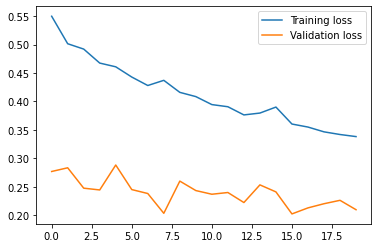

In [113]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Training loss", "Validation loss"])

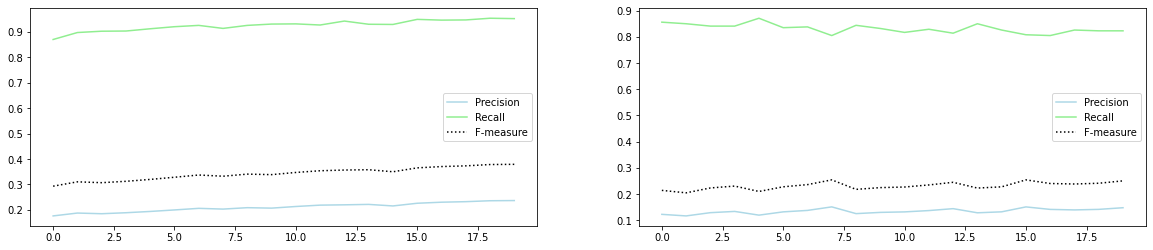

In [178]:
fig, axs = plt.subplots(1,2,figsize=(20,4))
# Prec. training
axs[0].plot([tp/(fp+tp) for (tp, fp) in zip(history.history['tp'], history.history['fp'])], color='lightblue')
# Rec. training
axs[0].plot([tp/(fn+tp) for (tp, fn) in zip(history.history['tp'], history.history['fn'])], color='lightgreen')
# F-measure
axs[0].plot([2*tp/(2*tp+fp+fn) for (tp, fp, fn) in zip(history.history['tp'], history.history['fp'], history.history['fn'])], 'k:')
axs[0].legend(["Precision", "Recall", "F-measure"])

# Prec. training
axs[1].plot([tp/(fp+tp) for (tp, fp) in zip(history.history['val_tp'], history.history['val_fp'])], color='lightblue')
# Rec. training
axs[1].plot([tp/(fn+tp) for (tp, fn) in zip(history.history['val_tp'], history.history['val_fn'])], color='lightgreen')
# F-measure
axs[1].plot([2*tp/(2*tp+fp+fn) for (tp, fp, fn) in zip(history.history['val_tp'], history.history['val_fp'], history.history['val_fn'])], 'k:')
axs[1].legend(["Precision", "Recall", "F-measure"])

In [114]:
training_name = "finetune-all-plus-dropout"
with open('results/cnn-training-220330/{}.pickle'.format(training_name), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [60]:
model.evaluate(X_test, y_test)


243/243 [==============================] - 11s 37ms/step - loss: 0.3848 - tp01: 392.0000 - tn01: 4660.0000 - fp01: 2718.0000 - fn01: 4.0000 - tp05: 373.0000 - tn05: 6076.0000 - fp05: 1302.0000 - fn05: 23.0000


[0.38476236363579, 392.0, 4660.0, 2718.0, 4.0, 373.0, 6076.0, 1302.0, 23.0]

## Audio analysis and onset extraction

In [168]:
F_RATE = HOP/SR 
test_audio_paths = ['datasets/initslurtest_vn/initslurtest_vn_wav/slurtest{:02d}.wav'.format(test_index+1) for test_index in test_idx]
test_audios = [madmom.audio.signal.load_wave_file(path)[0] for path in test_audio_paths]
test_lengths = [len(test_audio)/SR for test_audio in test_audios]
test_onsets = [genfromtxt('datasets/initslurtest_vn/initslurtest_vn_annotations/{:02d}.txt'.format(test_index+1), delimiter=',') for test_index in test_idx]
test_onset_vectors = [get_label_vector(test_onset, len(test_audio)/SR, HOP, SR) for test_audio, test_onset in zip(test_audios, test_onsets)]
print("Test recordings: ", test_idx+1)
print("Length of recordings: ", ["{:.1f} s".format(l) for l in test_lengths])
print([len(a)/HOP for a in test_audios])
print("Length of onset vectors: ", [len(v) for v in test_onset_vectors])
print("Number of annotated onsets: ", [len(test_onset) for test_onset in test_onsets])

/usr/local/lib/python3.9/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


Test recordings:  [13  6]
Length of recordings:  ['28.1 s', '49.6 s']
[2810.675736961451, 4962.104308390023]
Length of onset vectors:  [2811, 4963]
Number of annotated onsets:  [44, 350]


In [169]:
full_audio = np.concatenate(test_audios)
cum_lengths = np.concatenate(([0.0], np.cumsum(test_lengths)))[:-1]
full_onsets = np.concatenate(
    [shift + onset for (shift, onset) in zip(cum_lengths, test_onsets)]
)
full_onset_vectors = np.concatenate(test_onset_vectors)
full_onset_vectors[100]

0

In [170]:
from models.bock2013pret import get_model
(base_model, norm_layer)=get_model()
test_model_out = model.predict(X_test)

In [171]:
KERNEL_SIZE = 5
N_PRE = 5
N_POST = 1

test_peaks = madmom.features.onsets.peak_picking(
                                    activations=test_model_out, 
                                    threshold=0.5, 
                                    smooth=KERNEL_SIZE, 
                                    pre_avg=N_PRE, 
                                    post_avg=N_POST, 
                                    pre_max=N_PRE, 
                                    post_max=N_POST
)[0].astype(np.float32)*F_RATE

len(test_peaks)


431

[10.309999 10.57     10.84     11.38     11.96     12.45     13.04    ]


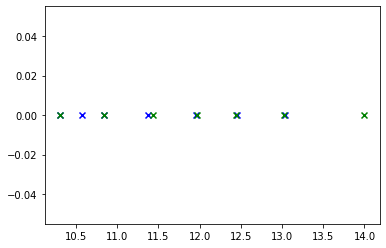

In [172]:
start_sec = 10
end_sec = 14
selected_peaks = test_peaks[np.intersect1d(
    np.where(test_peaks>=start_sec)[0],
    np.where(test_peaks<end_sec)[0])
]
selected_onsets = full_onsets[np.intersect1d(
    np.where(full_onsets>=start_sec)[0],
    np.where(full_onsets<end_sec)[0])
]
print(selected_peaks)
plt.scatter(selected_peaks, np.zeros_like(selected_peaks), marker='x', color='blue')
plt.scatter(selected_onsets, np.zeros_like(selected_onsets), marker='x', color='green')

In [175]:
from analyze_detection import evaluate

true = full_onsets
pred = test_peaks

TOL = 0.025
[CD,FN,FP,doubles,merged] = evaluate(true, pred, tol_sec=TOL)
print(CD)
print("Precision: {:.1f} %".format( 100*CD/(CD+FP)))
print("Recall: {:.1f} %".format( 100*CD/(CD+FN)))
print("F-score: {:.1f} %".format( 200*CD/(2*CD+FP+FN)))

372
Precision: 86.3 %
Recall: 94.4 %
F-score: 90.2 %


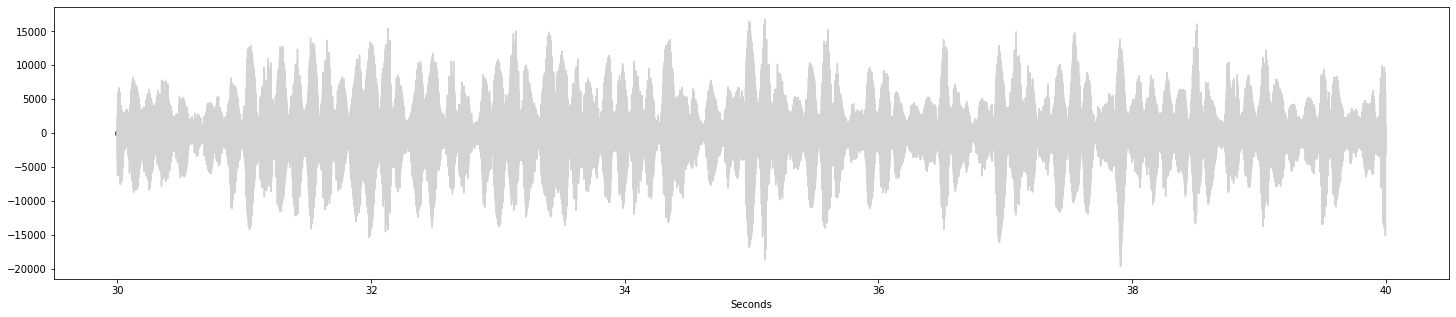

In [134]:
start_sec = 30
dur_sec = 10

selected_audio = full_audio[start_sec*SR:(start_sec+dur_sec)*SR]
selected_onsets = full_onsets[np.intersect1d(
        np.where(full_onsets>=start_sec)[0], 
        np.where(full_onsets<start_sec+dur_sec)[0]
)]
selected_onehot = full_onset_vectors[int(start_sec/F_RATE):int((start_sec+dur_sec)/F_RATE)]
fig = plt.figure(figsize=(25,5))
if start_sec + dur_sec < len(full_audio)/SR:
    
    
    plt.plot(
        np.linspace(start_sec, start_sec+dur_sec, dur_sec*SR),
        selected_audio, 
        color="lightgray"
    )
    for i, onset in enumerate(selected_onehot):
        if onset==1:
            plt.scatter(start_sec + i*F_RATE/dur_sec, 0, color='green')
    plt.xlabel("Seconds")
    plt.show()

else:
    print("Cannot plot selected region, choose other start/dur values")

0.01

Precision: 58.2 %
Recall: 61.5 %


In [ ]:
#f = open("datasets/initslurtest_vn/model-output/bockmodel-220315-slurtest{:02d}.txt".format(test_index), "w")
#for i in range(len(peaks)):
#    f.write(str(np.round((peaks[i]+7)*440/44100, decimals=2))+ "\n")
#f.close()